In the section 02 section, we tried to use K-means to classify some fruit images. However, we weren't very successful. It is because the "color vectors" obtained for the pixels of the image, that we were trying to use to classify the images, weren't very appropriate to describe pretty much anything that is not just color. 

At the same time, in the section 03 we saw that we can describe images using CNNs, and we trained a network to distinguish objects not only by their colors but also by their form. In the end, we were able to obtain feature vectors that we were "adding" in to 10 values to get a final one hot representation. However, before the final addition, what we have is a vector of visual features of the image, that we can use to try to find clusters in our images. 

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-01-24 18:09:13.747073: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 18:09:13.908329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 18:09:13.908404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 18:09:13.939000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 18:09:14.006656: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 18:09:14.008314: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

labels = np.unique(y_train)

# we normalize the data to be between 0 and 1
x_train_f = x_train.astype('float') / 255.
x_test_f = x_test.astype('float') / 255.

# we also convert the labels to one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=labels.size)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=labels.size)

# we initialize the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# we define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3))) 
model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(64, activation='relu')) 
model.add(tf.keras.layers.Dense(labels.size, activation='softmax')) 

# we compile and fit the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_f, y_train_oh, epochs=40, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# we evaluate the model
test_loss, test_acc = model.evaluate(x_test_f, y_test_oh)
print('Test accuracy:', test_acc)

2024-01-24 18:33:01.227791: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/40
1407/1407 [==============================] - 48s 34ms/step - loss: 1.4874 - accuracy: 0.4565 - val_loss: 1.2167 - val_accuracy: 0.5696
Epoch 2/40
1407/1407 [==============================] - 46s 33ms/step - loss: 1.0803 - accuracy: 0.6210 - val_loss: 0.9944 - val_accuracy: 0.6502
Epoch 3/40
1407/1407 [==============================] - 41s 29ms/step - loss: 0.9080 - accuracy: 0.6814 - val_loss: 1.0252 - val_accuracy: 0.6576
Epoch 4/40
1407/1407 [==============================] - 41s 29ms/step - loss: 0.7966 - accuracy: 0.7206 - val_loss: 0.9263 - val_accuracy: 0.6818
Epoch 5/40
1407/1407 [==============================] - 45s 32ms/step - loss: 0.7113 - accuracy: 0.7502 - val_loss: 0.8454 - val_accuracy: 0.7198
Epoch 6/40
1407/1407 [==============================] - 51s 36ms/step - loss: 0.6342 - accuracy: 0.7780 - val_loss: 0.8280 - val_accuracy: 0.7268
Epoch 7/40
1407/1407 [==============================] - 40s 28ms/step - loss: 0.5671 - accuracy: 0.8004 - val_loss: 0.8390 -

2024-01-24 18:44:29.160093: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 3s 8ms/step - loss: 1.0386 - accuracy: 0.7109
Test accuracy: 0.7109000086784363


In [26]:
# lets remove the last layer to have a model that outputs the features
model_features = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [5]:
# lets see wat the features look like
features = model_features.predict(x_test_f)
print(features.shape)

 12/313 [>.............................] - ETA: 1s 

2024-01-24 18:16:01.000962: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 2s 5ms/step
(10000, 64)


Lets also integrate the code from the section 02 that we need to load the fruit images

In [15]:
from PIL import Image
import numpy as np 
import os

SMALL_SIZE = 32
DATA_DIR = '../data'

# increase the maximum number of open files so that os can read the all the images in the directory
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (10000, 10000))

def resize(im, size=SMALL_SIZE):
    """Resize an image to the given size"""
    im = im.resize((size, size))
    return im

def load_images(path = os.path.join(DATA_DIR, "fruits")):
    """Load the data from the given path"""
    res = []
    res_small = []
    for filename in os.listdir(path):
        img = Image.open(os.path.join(path, filename))
        img = img.convert("RGB")
        res_small.append(np.array(resize(img, SMALL_SIZE)))
    return np.array(res_small)

data_small = load_images()

In [27]:
# we than extract the features from the fruit images
fruit_fratures = model_features.predict(data_small)

print(fruit_fratures.shape)

313/313 [==============================] - 3s 8ms/step
(10000, 64)


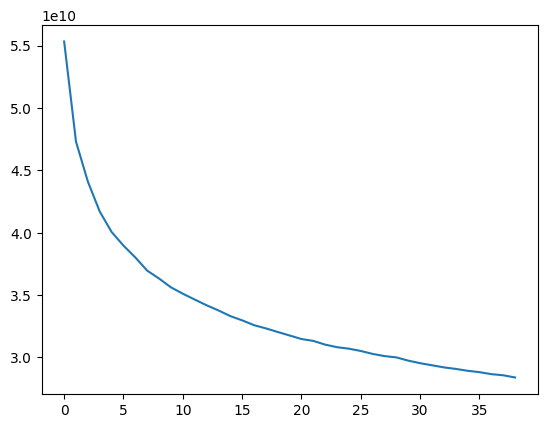

In [28]:
# now let's use kmeans to cluster the feature vectors with different number of clusters
from sklearn.cluster import KMeans

# we first normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(fruit_fratures)

# use inertia to find the best number of clusters
inertia = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 'auto').fit(fruit_fratures)
    inertia.append(kmeans.inertia_)
plt.plot(inertia)
plt.show()


We see the same descending curve withouth visible minimum reached. This isn't a good sign. 

In [29]:
import matplotlib.pyplot as plt
def display_images(images):
    """Display the first n images with their labels"""
    plt.figure(figsize=(20, 2))
    for j in range(len(images)):
        plt.subplot(1, len(images), j+1)
        plt.imshow(images[j])
    plt.show()

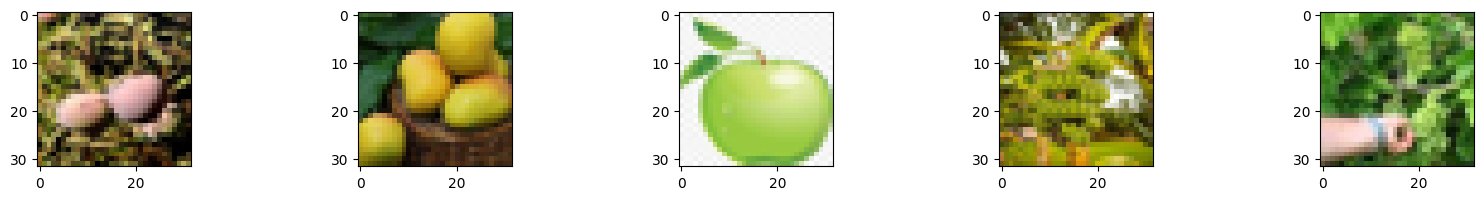

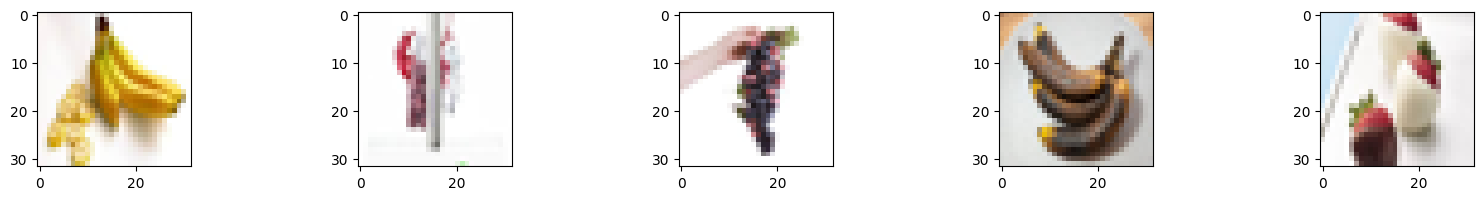

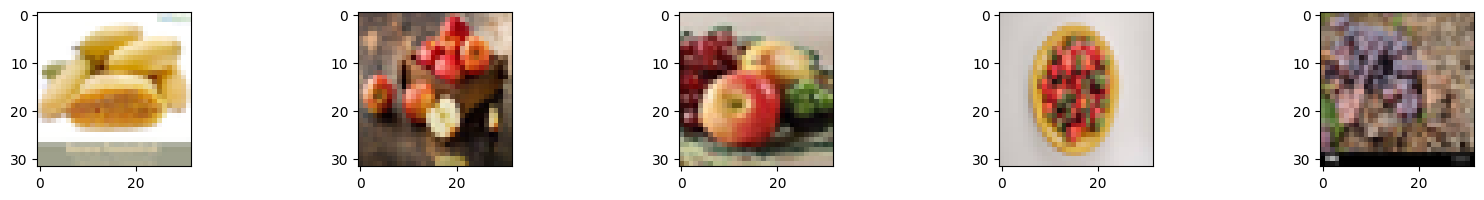

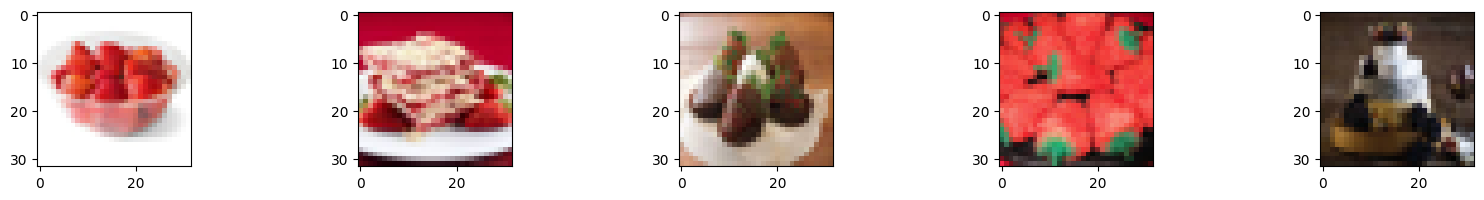

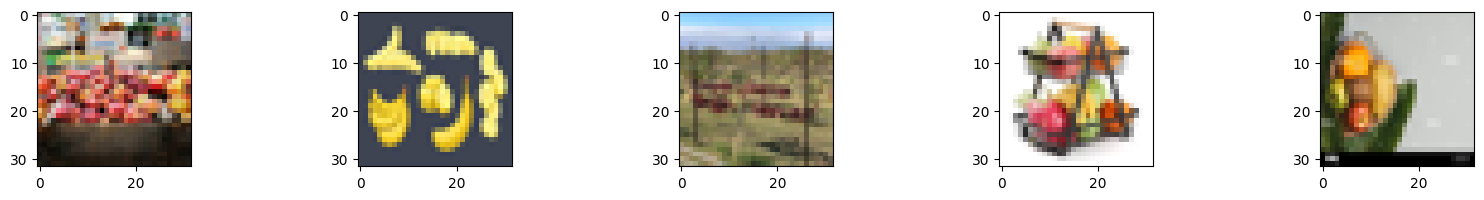

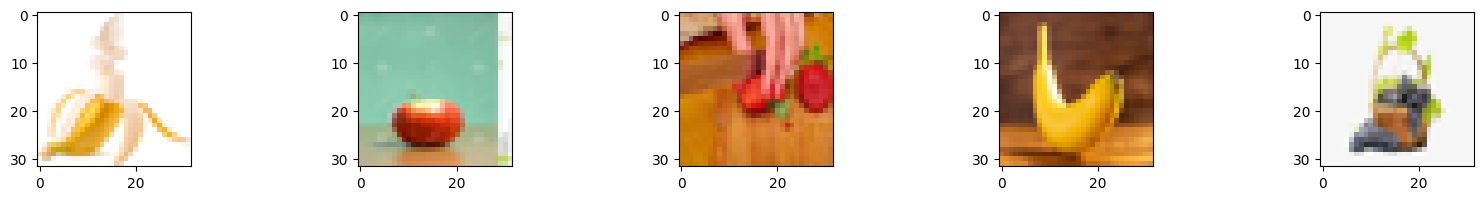

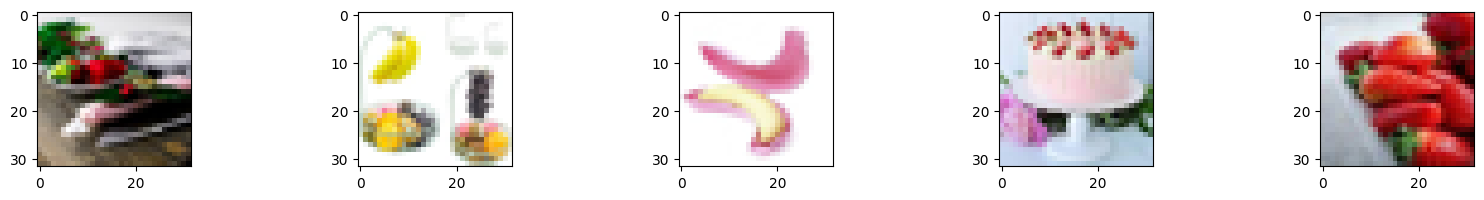

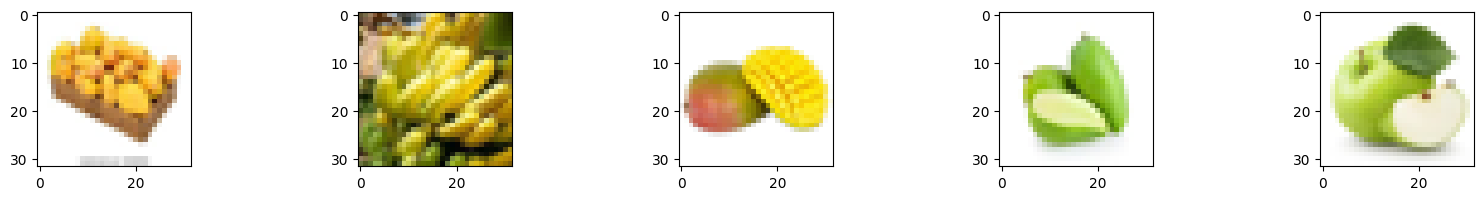

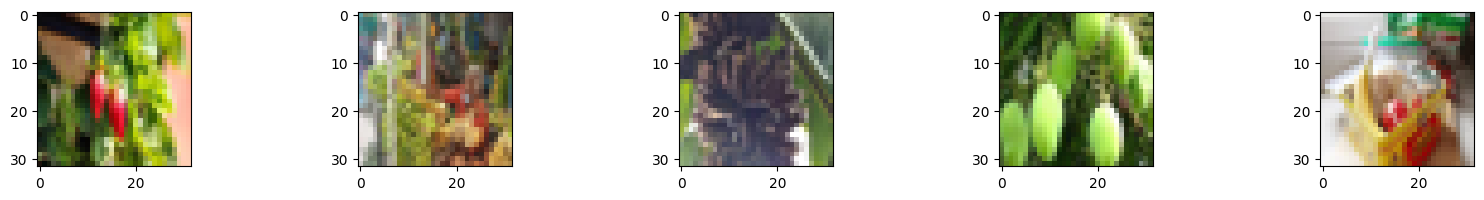

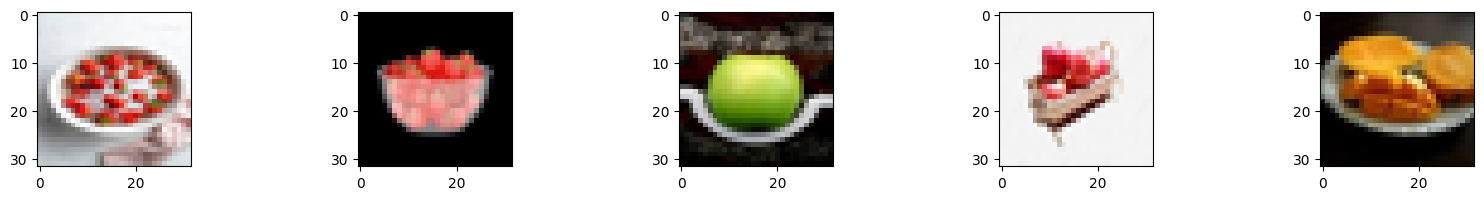

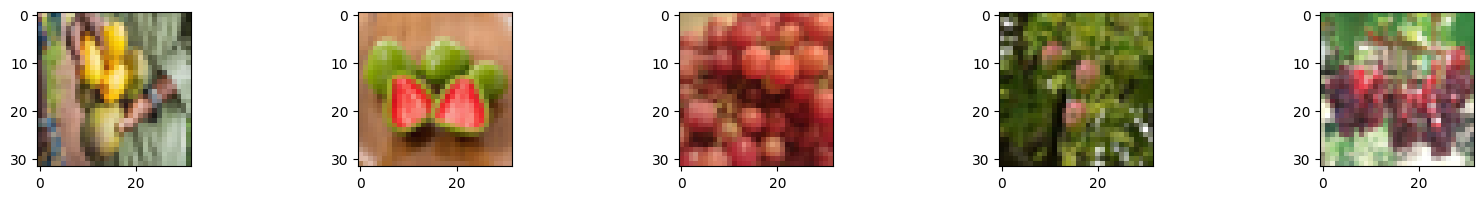

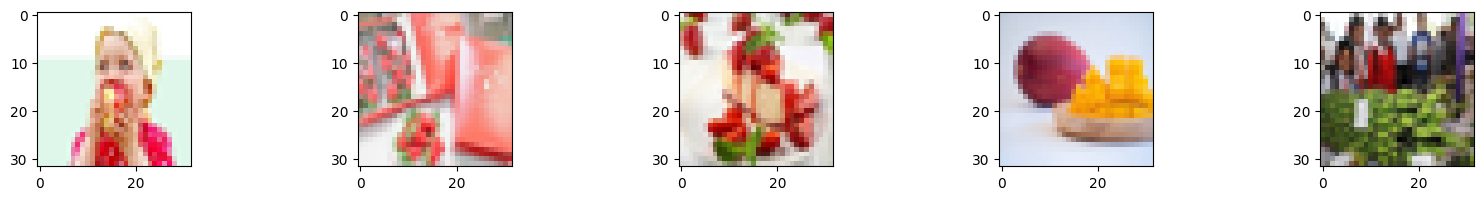

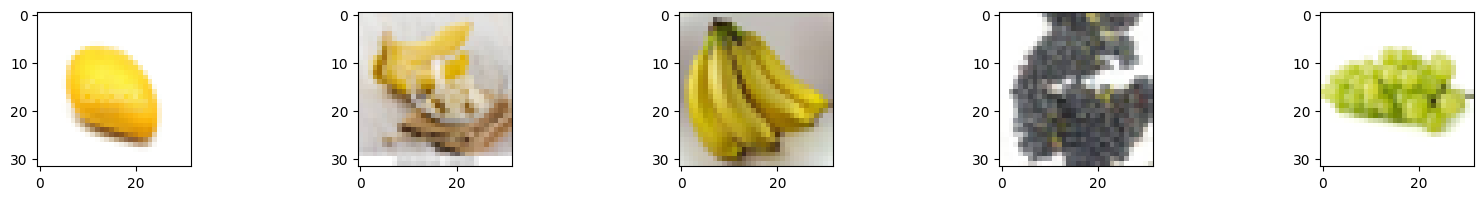

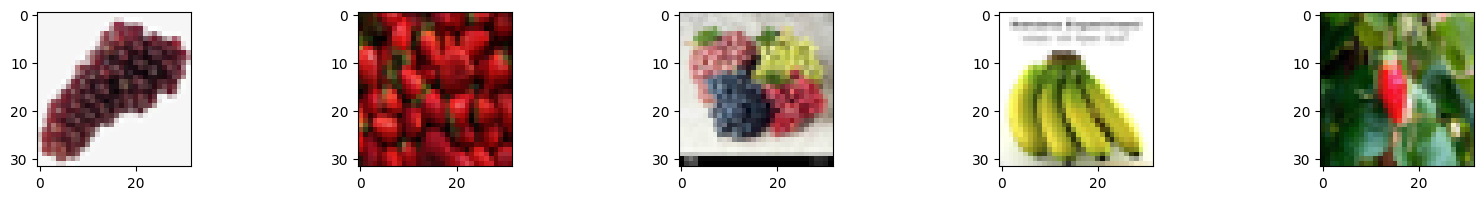

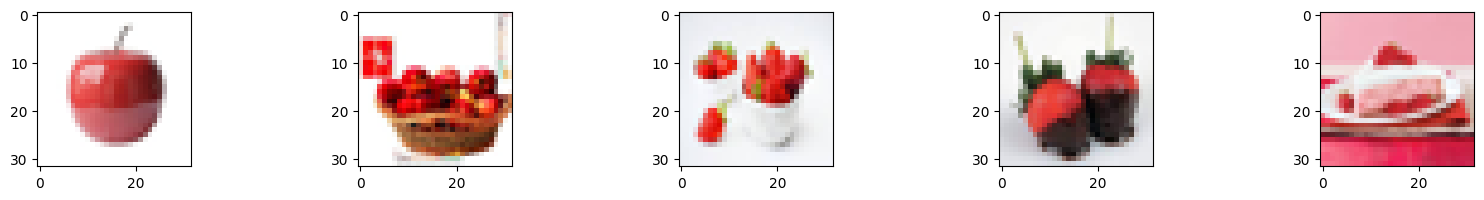

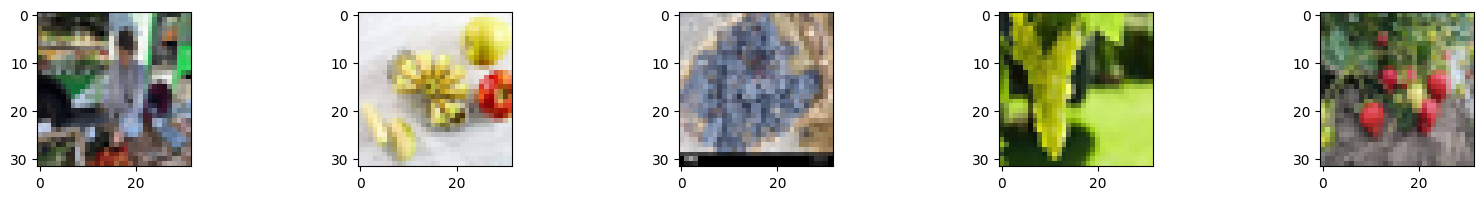

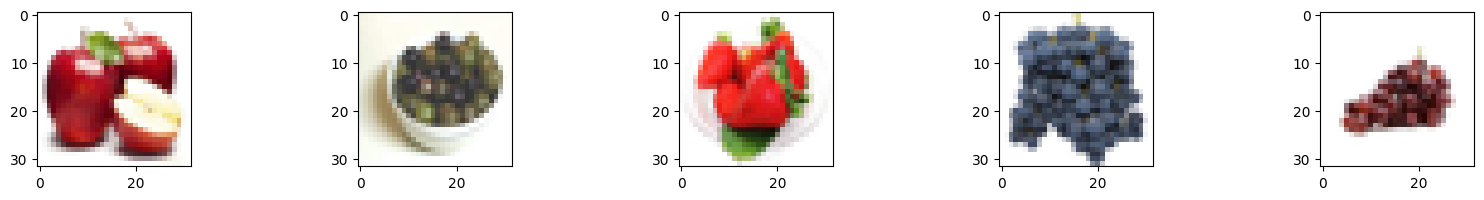

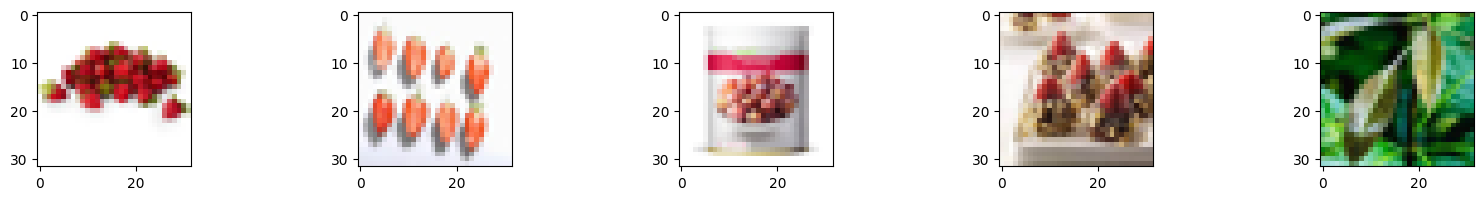

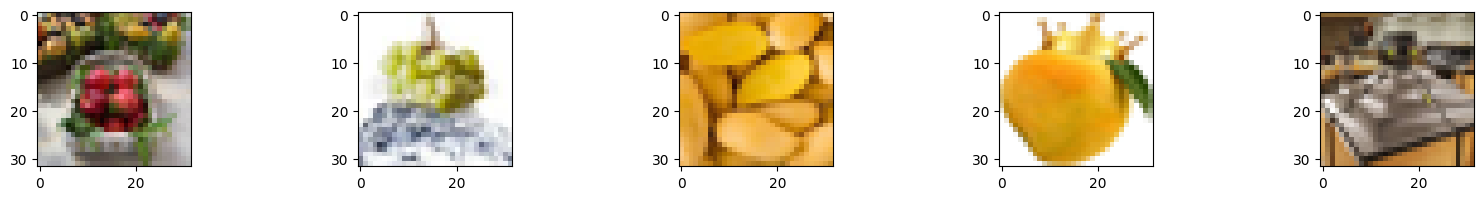

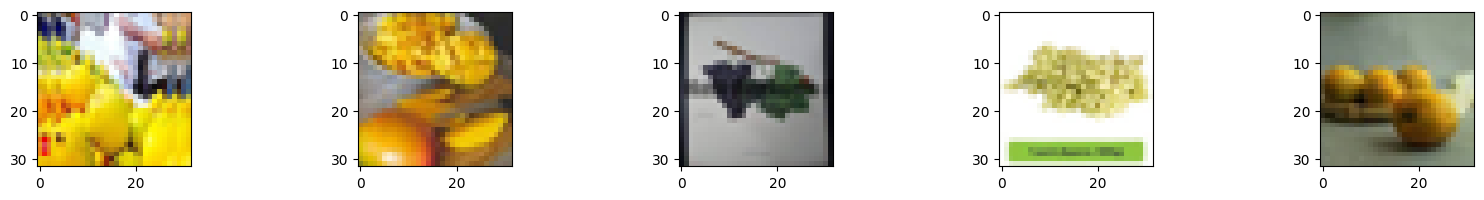

In [30]:
# display 10 first images from each cluster for data with 20 clusters
for i in range(20):
    display_images(data_small[kmeans.labels_ == i][:5])